# Lab 9: Đối ngẫu và Phương pháp Newton – Bài thực hành đơn giản

Trong lab ngắn này, bạn sẽ ôn lại khái niệm đối ngẫu lồi qua một ví dụ nhỏ đủ tính toán được bằng tay và mã Python, sau đó triển khai phương pháp Newton với backtracking line search. Mục tiêu là hiểu công thức, tự viết mã, và trực quan hoá đường đi của thuật toán.


## Mục tiêu và tiền đề
Trong lab này, bạn sẽ: 
- (i) củng cố khái niệm đối ngẫu lồi qua một ví dụ nhỏ có thể tính được tay và bằng Python, 
- (ii) tự cài đặt thuật toán Newton với backtracking line search cho bài toán tối ưu hoá không ràng buộc và 
- (iii) trực quan hoá quỹ đạo hội tụ so với gradient descent để cảm nhận lợi ích của thông tin Hessian

## Thiết lập
Chạy ô sau để import và cấu hình cơ bản.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook')
np.random.seed(42)

from typing import Callable, Tuple


## Phần A — Ôn tập đối ngẫu qua ví dụ đơn giản
Xét bài toán primal lồi dạng bình phương tối ưu hoá có ràng buộc tuyến tính nhỏ:

$$
\min_{x\in\mathbb{R}^n} \; f(x)=\tfrac{1}{2}\lVert x\rVert^2 + c^\top x\quad \text{s.t.}\quad a^\top x = b.
$$

Hàm Lagrange: $$\mathcal{L}(x,\lambda) = \tfrac{1}{2}\lVert x\rVert^2 + c^\top x + \lambda(a^\top x - b)$$. Với $\lambda\in\mathbb{R}$, đối ngẫu là $g(\lambda)=\inf_x \mathcal{L}(x,\lambda)$. 

Ta tìm $x(\lambda)$ thoả $\nabla_x\mathcal{L}=0\Rightarrow x(\lambda)=-(c+\lambda a)$. Thay vào thu được hàm đối ngẫu lồi-concave theo $\lambda$, và bài toán dual: $\max_\lambda g(\lambda)$.

Chúng ta sẽ cụ thể hoá với $n=2$, chọn $c, a, b$ và so sánh nghiệm primal-dual.


In [2]:
# Ví dụ đối ngẫu: n=2
c = np.array([1.0, -2.0])
a = np.array([2.0, 1.0])
b = 1.0

# x(lambda) = -(c + lambda a)
def x_of_lambda(lmbd: float) -> np.ndarray:
    return -(c + lmbd * a)

# g(lambda) = L(x(lambda), lambda) = 1/2||x||^2 + c^T x + lambda(a^T x - b)
# với x = x(lambda)
def g_dual(lmbd: float) -> float:
    x = x_of_lambda(lmbd)
    return 0.5 * np.dot(x, x) + np.dot(c, x) + lmbd * (np.dot(a, x) - b)

# maximize g(lambda) (concave) -> ta có thể tìm đạo hàm g'(lambda)=0
# Tính analytic: a^T x(lambda) - b = 0 => a^T (-(c + lambda a)) - b = 0
# => -(a^T c) - lambda * (a^T a) - b = 0 => lambda* = -(a^T c + b)/(a^T a)
lam_star = -(np.dot(a, c) + b) / np.dot(a, a)
x_star_dual = x_of_lambda(lam_star)

print('lambda* =', lam_star)
print('x*(dual-induced) =', x_star_dual)

# Kiểm tra ràng buộc a^T x = b
print('a^T x =', np.dot(a, x_star_dual), '(mong đợi ~ b =', b, ')')


lambda* = -0.2
x*(dual-induced) = [-0.6  2.2]
a^T x = 1.0000000000000002 (mong đợi ~ b = 1.0 )


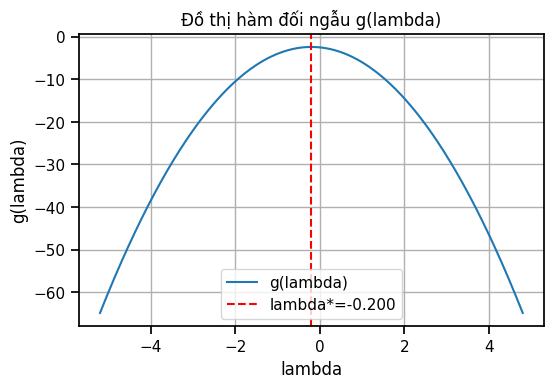

In [3]:
# Vẽ đồ thị g(lambda)
lmbd_grid = np.linspace(lam_star - 5, lam_star + 5, 400)
vals = np.array([g_dual(l) for l in lmbd_grid])

plt.figure(figsize=(6,3.8))
plt.plot(lmbd_grid, vals, label='g(lambda)')
plt.axvline(lam_star, color='r', linestyle='--', label=f'lambda*={lam_star:.3f}')
plt.xlabel('lambda'); plt.ylabel('g(lambda)')
plt.title('Đồ thị hàm đối ngẫu g(lambda)')
plt.legend(); plt.grid(True)
plt.show()


## Phần B — Phương pháp Newton với backtracking
Ta xét hàm Rosenbrock kinh điển $f(x,y) = (1-x)^2 + 100(y - x^2)^2$. Viết gradient, Hessian, sau đó cài đặt Newton với điều kiện Armijo (backtracking). So sánh quỹ đạo với Gradient Descent để cảm nhận cải thiện điều kiện hoá.


### Backtracking Line Search

Mục tiêu: tìm hệ số bước \( \alpha > 0 \) sao cho điều kiện Armijo được thỏa mãn.

$$
\alpha_{k+1} = \rho \, \alpha_k, \quad 0 < \rho < 1
$$

$$
f(x + \alpha d) \le f(x) + c \alpha \nabla f(x)^\top d, \quad 0 < c < 1
$$

---

### Newton Method

Tại bước \( k \):

$$
\nabla f(x_k) = g_k, \quad \nabla^2 f(x_k) = H_k
$$

Phương trình Newton:

$$
H_k p_k = -g_k \quad \Rightarrow \quad p_k = -H_k^{-1} g_k
$$

Cập nhật nghiệm:

$$
x_{k+1} = x_k + \alpha_k p_k
$$

Nếu \( H_k \) suy biến, dùng nghịch đảo giả:

$$
p_k = -H_k^{+} g_k
$$

Tiêu chí dừng:

$$
\|\nabla f(x_k)\| < \text{tol}
$$

---

### Gradient Descent (Hạ dốc)

Cập nhật theo hướng âm gradient:

$$
x_{k+1} = x_k - \eta \nabla f(x_k)
$$

Tiêu chí dừng:

$$
\|\nabla f(x_k)\| < \text{tol}
$$



In [4]:
def rosenbrock(x: np.ndarray) -> float:
    X, Y = x[0], x[1]
    return (1 - X)**2 + 100.0 * (Y - X**2)**2

def grad_rosenbrock(x: np.ndarray) -> np.ndarray:
    X, Y = x[0], x[1]
    dfdx = -2*(1 - X) - 400*X*(Y - X**2)
    dfdy = 200*(Y - X**2)
    return np.array([dfdx, dfdy])

def hess_rosenbrock(x: np.ndarray) -> np.ndarray:
    X, Y = x[0], x[1]
    dxx = 2 - 400*(Y - 3*X**2)
    dxy = -400*X
    dyx = -400*X
    dyy = 200
    return np.array([[dxx, dxy], [dyx, dyy]])


In [5]:
def backtracking_line_search(f: Callable[[np.ndarray], float],
                             grad: Callable[[np.ndarray], np.ndarray],
                             x: np.ndarray,
                             direction: np.ndarray,
                             alpha_init: float = 1.0,
                             rho: float = 0.5,
                             c: float = 1e-4) -> float:
    f_x = f(x)
    grad_x = grad(x)
    alpha = alpha_init
    while f(x + alpha * direction) > f_x + c * alpha * np.dot(grad_x, direction):
        alpha *= rho
        if alpha < 1e-12:
            break
    return alpha


def newton_method(f: Callable[[np.ndarray], float],
                  grad: Callable[[np.ndarray], np.ndarray],
                  hess: Callable[[np.ndarray], np.ndarray],
                  x0: np.ndarray,
                  tol: float = 1e-8,
                  max_iter: int = 50,
                  line_search: bool = True) -> Tuple[np.ndarray, list]:
    x = x0.astype(float).copy()
    hist = [x.copy()]
    for _ in range(max_iter):
        g = grad(x)
        H = hess(x)
        if np.linalg.norm(g) < tol:
            break
        try:
            p = -np.linalg.solve(H, g)
        except np.linalg.LinAlgError:
            # Nếu Hessian suy biến, dùng pseudo-inverse
            p = -np.linalg.pinv(H) @ g
        step = backtracking_line_search(f, grad, x, p) if line_search else 1.0
        x = x + step * p
        hist.append(x.copy())
    return x, hist


def gradient_descent(f: Callable[[np.ndarray], float],
                     grad: Callable[[np.ndarray], np.ndarray],
                     x0: np.ndarray,
                     lr: float = 1e-3,
                     max_iter: int = 5000,
                     tol: float = 1e-8) -> Tuple[np.ndarray, list]:
    x = x0.astype(float).copy()
    hist = [x.copy()]
    for _ in range(max_iter):
        g = grad(x)
        if np.linalg.norm(g) < tol:
            break
        x = x - lr * g
        hist.append(x.copy())
    return x, hist


In [6]:
# Chạy thử Newton vs GD trên Rosenbrock
x0 = np.array([-1.2, 1.0])

x_newton, hist_newton = newton_method(rosenbrock, grad_rosenbrock, hess_rosenbrock, x0, max_iter=30)
x_gd, hist_gd = gradient_descent(rosenbrock, grad_rosenbrock, x0, lr=1e-3, max_iter=50000)

print('Newton x* ~', x_newton, 'f* ~', rosenbrock(x_newton))
print('GD     x* ~', x_gd, 'f* ~', rosenbrock(x_gd))


Newton x* ~ [1. 1.] f* ~ 3.743975643139474e-21
GD     x* ~ [0.99999999 0.99999998] f* ~ 1.2517703123711922e-16


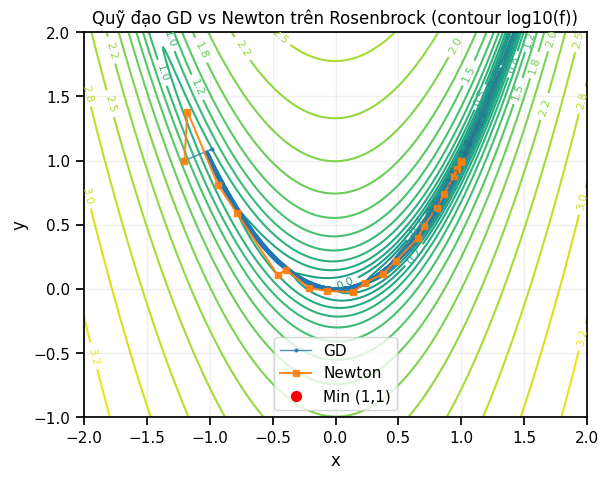

In [7]:
# Vẽ quỹ đạo trên contour f
hist_newton_arr = np.array(hist_newton)
hist_gd_arr = np.array(hist_gd)

# Lưới để vẽ contour
xv = np.linspace(-2, 2, 400)
yv = np.linspace(-1, 2, 400)
XX, YY = np.meshgrid(xv, yv)
ZZ = (1-XX)**2 + 100*(YY-XX**2)**2

plt.figure(figsize=(6.5,5))
cs = plt.contour(XX, YY, np.log10(ZZ+1e-6), levels=30, cmap='viridis')
plt.clabel(cs, inline=True, fontsize=8, fmt='%.1f')
plt.plot(hist_gd_arr[:,0], hist_gd_arr[:,1], '-o', ms=2, lw=1, label='GD', alpha=0.8)
plt.plot(hist_newton_arr[:,0], hist_newton_arr[:,1], '-s', ms=4, lw=1.5, label='Newton', alpha=0.9)
plt.scatter([1],[1], c='red', s=50, label='Min (1,1)')
plt.legend(); plt.xlabel('x'); plt.ylabel('y')
plt.title('Quỹ đạo GD vs Newton trên Rosenbrock (contour log10(f))')
plt.grid(True, alpha=0.2)
plt.show()


## Phần B — Ví dụ bổ sung: Newton có/không backtracking trên Rosenbrock
Để minh hoạ vai trò của backtracking (điều kiện Armijo) trong phương pháp Newton, ta so sánh Newton với backtracking và Newton full-step (không backtracking) từ một điểm khởi tạo khác trên hàm Rosenbrock, đồng thời hiển thị quỹ đạo và giá trị hàm mục tiêu để thấy sự khác biệt về độ ổn định và tốc độ hội tụ.


Newton BT  x* ~ [1. 1.] f* ~ 9.03011543396821e-28
Newton FS  x* ~ [1.         0.99999999] f* ~ 1.7356651173954362e-17
GD (alt)   x* ~ [0.99999999 0.99999998] f* ~ 1.2512382021494877e-16


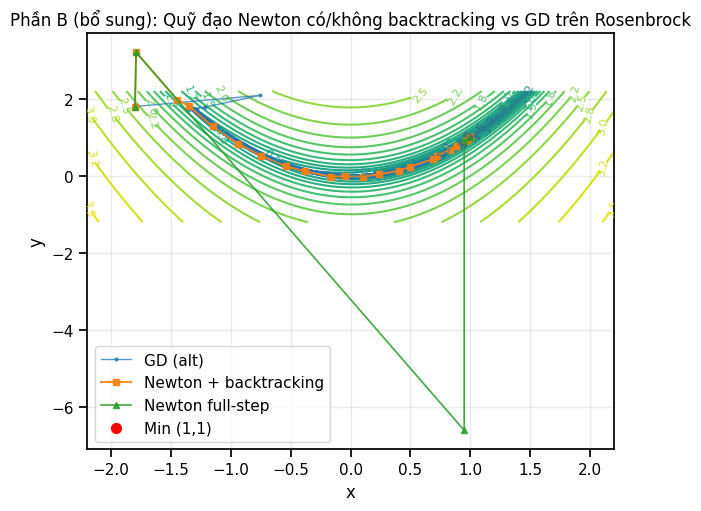

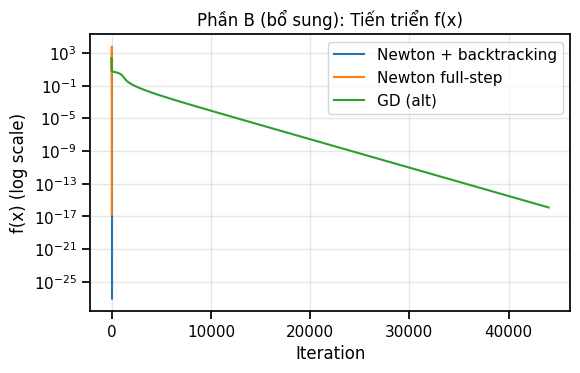

In [8]:
# Ví dụ bổ sung Phần B: Newton có/không backtracking vs GD trên Rosenbrock
# Dùng khởi tạo khác để quan sát khác biệt ổn định
x0_alt = np.array([-1.8, 1.8])

# Newton với backtracking (đã có hàm newton_method)
x_newton_bt, hist_newton_bt = newton_method(rosenbrock, grad_rosenbrock, hess_rosenbrock,
                                            x0_alt, max_iter=40, line_search=True)

# Newton full-step (không backtracking): tận dụng newton_method với line_search=False
x_newton_fs, hist_newton_fs = newton_method(rosenbrock, grad_rosenbrock, hess_rosenbrock,
                                            x0_alt, max_iter=40, line_search=False)

# Gradient Descent giữ nguyên lr như trước để tham chiếu
x_gd_alt, hist_gd_alt = gradient_descent(rosenbrock, grad_rosenbrock, x0_alt, lr=1e-3, max_iter=80000)

print('Newton BT  x* ~', x_newton_bt, 'f* ~', rosenbrock(x_newton_bt))
print('Newton FS  x* ~', x_newton_fs, 'f* ~', rosenbrock(x_newton_fs))
print('GD (alt)   x* ~', x_gd_alt,    'f* ~', rosenbrock(x_gd_alt))

# Vẽ quỹ đạo
h_bt = np.array(hist_newton_bt)
h_fs = np.array(hist_newton_fs)
h_gd = np.array(hist_gd_alt)

xv = np.linspace(-2.2, 2.2, 450)
yv = np.linspace(-1.2, 2.2, 450)
XX, YY = np.meshgrid(xv, yv)
ZZ = (1-XX)**2 + 100*(YY-XX**2)**2

plt.figure(figsize=(6.8,5.4))
cs = plt.contour(XX, YY, np.log10(ZZ+1e-6), levels=35, cmap='viridis')
plt.clabel(cs, inline=True, fontsize=8, fmt='%.1f')
plt.plot(h_gd[:,0], h_gd[:,1], '-o', ms=2, lw=1, label='GD (alt)', alpha=0.75)
plt.plot(h_bt[:,0], h_bt[:,1], '-s', ms=4, lw=1.4, label='Newton + backtracking', alpha=0.9)
plt.plot(h_fs[:,0], h_fs[:,1], '-^', ms=4, lw=1.2, label='Newton full-step', alpha=0.9)
plt.scatter([1],[1], c='red', s=50, label='Min (1,1)')
plt.legend(); plt.xlabel('x'); plt.ylabel('y')
plt.title('Phần B (bổ sung): Quỹ đạo Newton có/không backtracking vs GD trên Rosenbrock')
plt.grid(True, alpha=0.25)
plt.show()

# Vẽ tiến triển giá trị hàm mục tiêu theo iteration
plt.figure(figsize=(6.2,3.6))
f_bt = [rosenbrock(p) for p in h_bt]
f_fs = [rosenbrock(p) for p in h_fs]
f_gd = [rosenbrock(p) for p in h_gd]
plt.semilogy(f_bt, label='Newton + backtracking')
plt.semilogy(f_fs, label='Newton full-step')
plt.semilogy(f_gd, label='GD (alt)')
plt.xlabel('Iteration'); plt.ylabel('f(x) (log scale)')
plt.title('Phần B (bổ sung): Tiến triển f(x)')
plt.legend(); plt.grid(True, which='both', alpha=0.3)
plt.show()


## Phần C — Bài tập hàm đơn giản
Ba bài này giúp luyện Newton trên các hàm cơ bản: 1D bậc bốn (lồi), quadratic trục chuẩn 2D


In [9]:
# Newton 1D với backtracking
from typing import Callable

def backtracking_1d(f: Callable[[float], float], df: Callable[[float], float], x: float,
                    p: float, alpha_init: float = 1.0, rho: float = 0.5, c: float = 1e-4) -> float:
    fx = f(x)
    g = df(x)
    alpha = alpha_init
    while f(x + alpha * p) > fx + c * alpha * g * p:
        alpha *= rho
        if alpha < 1e-12:
            break
    return alpha


def newton_1d(f: Callable[[float], float], df: Callable[[float], float], d2f: Callable[[float], float],
              x0: float, max_iter: int = 50, tol: float = 1e-8) -> tuple[float, list]:
    x = float(x0)
    hist = [x]
    for _ in range(max_iter):
        g = df(x)
        if abs(g) < tol:
            break
        H = d2f(x)
        # tránh chia cho 0, thêm đệm nhỏ nếu cần
        if abs(H) < 1e-12:
            H = 1e-12 if H >= 0 else -1e-12
        p = - g / H
        alpha = backtracking_1d(f, df, x, p)
        x = x + alpha * p
        hist.append(x)
    return x, hist


### Bài: Newton 1D trên hàm bậc bốn
Xét $f(x) = (x-2)^4 + 0.5\,(x+1)^2$. Viết đạo hàm bậc nhất, bậc hai và chạy Newton từ nhiều điểm khởi tạo. Vẽ đồ thị 1D kèm các điểm lặp.


Init  -4.0 -> x*=1.182817, f*=2.828286e+00, iters=9
Init   0.0 -> x*=1.182817, f*=2.828286e+00, iters=6
Init   4.0 -> x*=1.182817, f*=2.828286e+00, iters=9


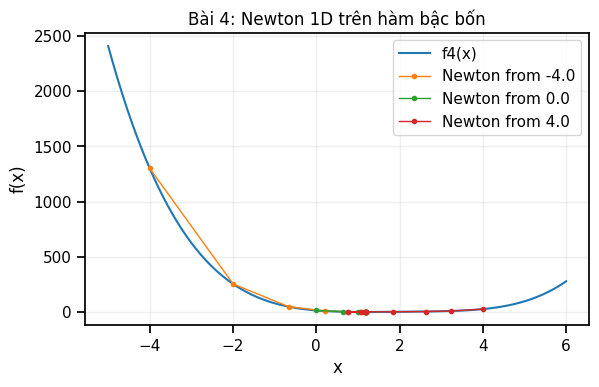

In [10]:
# Bài 4
f4 = lambda x: (x-2.0)**4 + 0.5*(x+1.0)**2
df4 = lambda x: 4*(x-2.0)**3 + (x+1.0)
d2f4 = lambda x: 12*(x-2.0)**2 + 1.0

inits = [-4.0, 0.0, 4.0]
traj_4 = []
for x0 in inits:
    x_star, hist = newton_1d(f4, df4, d2f4, x0)
    traj_4.append((x0, x_star, hist))
    print(f'Init {x0:5.1f} -> x*={x_star:.6f}, f*={f4(x_star):.6e}, iters={len(hist)-1}')

# Vẽ
xs = np.linspace(-5, 6, 600)
ys = np.array([f4(x) for x in xs])
plt.figure(figsize=(6.5,3.8))
plt.plot(xs, ys, label='f4(x)')
for x0, x_star, hist in traj_4:
    pts_x = np.array(hist)
    pts_y = np.array([f4(x) for x in pts_x])
    plt.plot(pts_x, pts_y, '-o', ms=3, lw=1, label=f'Newton from {x0}')
plt.xlabel('x'); plt.ylabel('f(x)'); plt.title('Bài 4: Newton 1D trên hàm bậc bốn')
plt.legend(); plt.grid(True, alpha=0.2)
plt.show()


### Bài 5: Quadratic trục chuẩn 2D
Xét $f(x)=\tfrac{1}{2}x^\top Q x + q^\top x$ với $Q=\operatorname{diag}(1, 50)$ và $q=(-2,1)$. So sánh Newton (H=Q) và GD, vẽ contour và quỹ đạo.


Diag Quad: Newton x* ~ [ 2.   -0.02] f* ~ -2.0099999999999993
Diag Quad: GD     x* ~ [ 2.00000001 -0.02      ] f* ~ -2.01


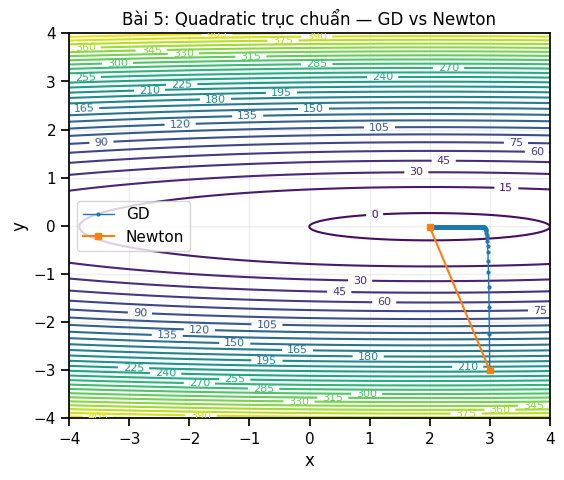

In [11]:

# Bài 5
Qd = np.diag([1.0, 50.0])
qd = np.array([-2.0, 1.0])
fd = lambda x: 0.5 * x @ Qd @ x + qd @ x
gd = lambda x: Qd @ x + qd
Hd = lambda x: Qd

x0 = np.array([3.0, -3.0])
xN, hN = newton_method(fd, gd, Hd, x0, max_iter=10)
xG, hG = gradient_descent(fd, gd, x0, lr=5e-3, max_iter=20000)
print('Diag Quad: Newton x* ~', xN, 'f* ~', fd(xN))
print('Diag Quad: GD     x* ~', xG, 'f* ~', fd(xG))

hN = np.array(hN); 
hG = np.array(hG)
xv = np.linspace(-4, 4, 300)
yv = np.linspace(-4, 4, 300)
XX, YY = np.meshgrid(xv, yv)
ZZ = 0.5*(Qd[0,0]*XX**2 + 2*Qd[0,1]*XX*YY + Qd[1,1]*YY**2) + qd[0]*XX + qd[1]*YY

plt.figure(figsize=(6.2,5))
cs = plt.contour(XX, YY, ZZ, levels=30, cmap='viridis')
plt.clabel(cs, inline=True, fontsize=8)
plt.plot(hG[:,0], hG[:,1], '-o', ms=2, lw=1, label='GD')
plt.plot(hN[:,0], hN[:,1], '-s', ms=4, lw=1.5, label='Newton')
plt.legend(); plt.xlabel('x'); plt.ylabel('y'); plt.title('Bài 5: Quadratic trục chuẩn — GD vs Newton')
plt.grid(True, alpha=0.2)
plt.show()
